# 1. Can you make the RNN model overfit using the high-level APIs?

# 2. Implement the autoregressive model of Section 9.1 using an RNN.

In [17]:
import numpy as np
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
from torch.nn import functional as F
from sklearn.model_selection import ParameterGrid
warnings.filterwarnings("ignore")

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, randn=0.2):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
class RNN(d2l.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)
    
class RNNAutoRegression(d2l.LinearRegression):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(1)

    # def output_layer(self, hiddens):
    #     return self.linear(hiddens).swapaxes(0, 1)
    
    def __init__(self, rnn,lr=0.01, tau=4, plot_flag=True, emb_len=8):
        super().__init__(lr=lr)
        self.save_hyperparameters()
        self.init_params()   

    def forward(self, X, state=None):
        rnn_outputs, _ = self.rnn(X, state)
        # return self.output_layer(rnn_outputs)
        return rnn_outputs


(2.3052653446793556, 1.5281194541603327)

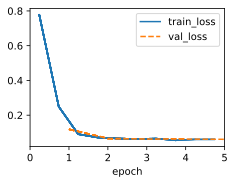

In [18]:
tau=4
data = Data(tau=tau)
rnn = RNN(num_inputs=tau, num_hiddens=2)
model = RNNAutoRegression(rnn=rnn, lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

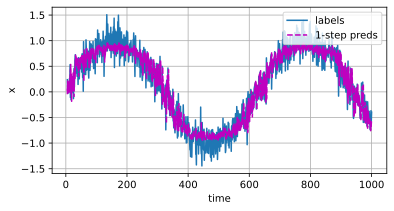

In [19]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

In [24]:
i=data.num_train + data.tau
model(multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

In [23]:
(data.num_train + data.tau, data.T)

(604, 1000)

In [20]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

RuntimeError: expand(torch.FloatTensor{[2]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)